In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, mean_squared_error

In [15]:
# Define image dimensions for preprocessing.
height = 300
width = 300

In [16]:
# Define directories for training and validation data.
train_dir = "Dataset(50)\Training"
validation_dir = "Dataset(50)\Validation"


In [17]:
# Number of batches for data generators.
batch_size = 8


In [18]:
# Data augmentation for training images.
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=90,
                                   horizontal_flip=True, vertical_flip=True)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(height, width),
                                                    batch_size=batch_size, class_mode='binary')


Found 34 images belonging to 2 classes.


In [19]:
# Data augmentation for validation images.
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=90,
                                        horizontal_flip=True, vertical_flip=True)
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(height, width),
                                                              batch_size=batch_size, class_mode='binary')


Found 31 images belonging to 2 classes.


In [20]:
# Load ResNet50 model without top layer.
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(height, width, 3))


In [21]:
# Add custom top layers for classification.
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)


In [22]:
# Combine base model with custom top layers
finetune_model = Model(inputs=base_model.input, outputs=predictions)

In [23]:
# Freeze layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [24]:
# Compile the model
finetune_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])


In [25]:

# Checkpoint and early stopping
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max', restore_best_weights=True)


In [26]:
# Train the model on training data with validation on validation data.
history = finetune_model.fit(train_generator, steps_per_epoch=len(train_generator),epochs=100,validation_data=validation_generator, validation_steps=len(validation_generator),callbacks=[checkpoint, early_stop])


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9242 - loss: 0.9971
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 95s 19s/step - accuracy: 0.9271 - loss: 1.0879 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 1.0000 - loss: 5.1162e-30 
Epoch 2: val_accuracy did not improve from 1.00000
5/5 ━━━━━━━━━━━━━━━━━━━━ 69s 13s/step - accuracy: 1.0000 - loss: 6.1110e-30 - val_accuracy: 0.9677 - val_loss: 6.8484
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67s/step - accuracy: 0.9299 - loss: 15.3539  
Epoch 3: val_accuracy did not improve from 1.00000
5/5 ━━━━━━━━━━━━━━━━━━━━ 287s 69s/step - accuracy: 0.9318 - loss: 14.1947 - val_accuracy: 1.0000 - val_loss: 3.6153e-11
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9941 - loss: 3.9018     
Epoch 4: val_accuracy did not improve from 1.00000
5/5 ━━━━━━━━━━━━━━━━━━━━ 62s 13s/step - accuracy: 0.9902 - loss: 6.5030 - val_accuracy: 0.9032 - val_loss: 14.1339
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9406 - loss: 2.5768 
Epoch 5: val_accuracy did not 

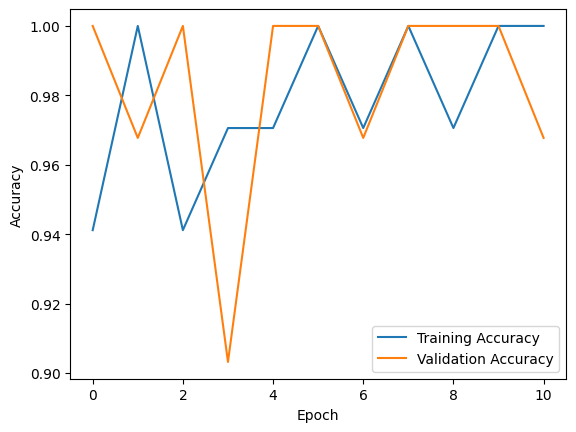

In [27]:
# Plot training and validation accuracy over epochs.
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


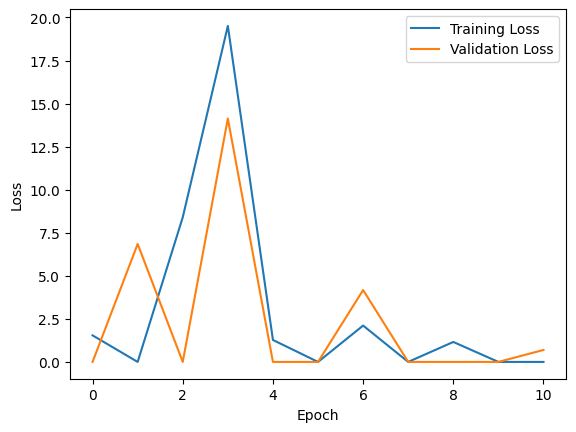

In [28]:
# Plot training and validation loss over epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [29]:
# Testing the model
def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(height, width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    if prediction[0][0] > 0.5:
        return "Real"
    else:
        return "Fake"

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


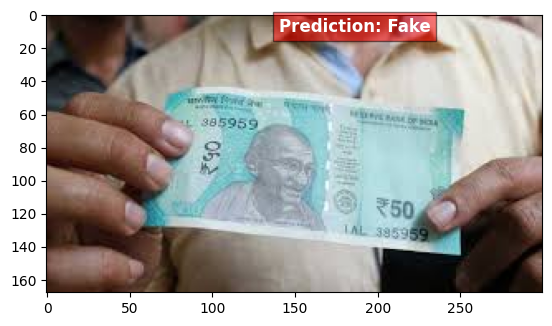

Prediction: Fake


In [30]:
# Specify the image path
test_img_path = r"Dataset(50)\Testing\Fake\1.jpeg"

# Load and display the image
img = image.load_img(test_img_path)
plt.imshow(img)

# Predict the image and display the prediction
prediction = predict_image(finetune_model, test_img_path)

img_width, img_height = img.size

# Use plt.text to add the prediction on the image
plt.text(img_width - 160, 10,f'Prediction: {prediction}', fontsize=12, color='white', weight='bold', bbox=dict(facecolor='red', alpha=0.5))

# Show the modified plot
plt.show()

# Print the prediction in the console if needed
print("Prediction:", prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


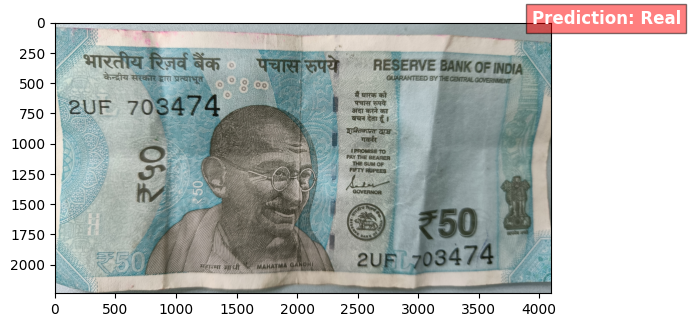

Prediction: Real


In [31]:
# Specify the image path
test_img_path =r"Dataset(50)\Testing\Real\1.jpg"

# Load and display the image
img = image.load_img(test_img_path)
plt.imshow(img)

# Predict the image and display the prediction
prediction = predict_image(finetune_model, test_img_path)

img_width, img_height = img.size

# Use plt.text to add the prediction on the image
plt.text(img_width - 160, 10,f'Prediction: {prediction}', fontsize=12, color='white', weight='bold', bbox=dict(facecolor='red', alpha=0.5))

# Show the modified plot
plt.show()

# Print the prediction in the console if needed
print("Prediction:", prediction)


In [32]:
overall_accuracy_training = finetune_model.evaluate(
    train_generator,
    steps=len(train_generator),
    verbose=1
)

print("Overall Accuracy on Training Set:", overall_accuracy_training[1])


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 931ms/step - accuracy: 1.0000 - loss: 1.4452e-24
Overall Accuracy on Training Set: 1.0


In [33]:
# Calculate overall accuracy of the model on the validation set.
overall_accuracy = finetune_model.evaluate(
    validation_generator,
    steps=len(validation_generator),
    verbose=1
)

# Print overall accuracy.
print("Validation Accuracy:", overall_accuracy[1])


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 994ms/step - accuracy: 1.0000 - loss: 5.1961e-22
Validation Accuracy: 1.0


Found 31 images belonging to 2 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step 


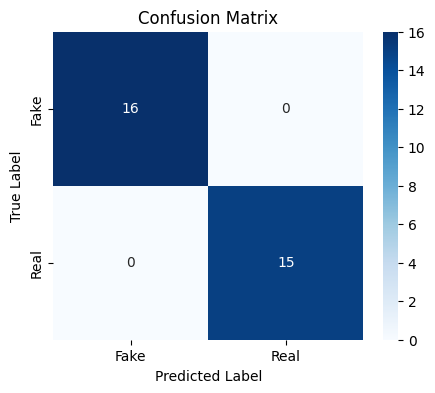

In [34]:
# Predict the whole validation set
validation_generator_predict = validation_datagen.flow_from_directory(validation_dir, target_size=(height, width),
                                                                      batch_size=batch_size, class_mode='binary', shuffle=False)
validation_generator_predict.reset()
predictions = finetune_model.predict(validation_generator_predict, steps=len(validation_generator_predict), verbose=1)
predicted_classes = (predictions > 0.5).astype(int)
true_classes = validation_generator_predict.classes

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [35]:
# Mean Squared Error
mse = mean_squared_error(true_classes, predicted_classes)
print(f"Mean Squared Error: {mse*100}")

Mean Squared Error: 0.0


In [36]:
finetune_model.save("model_50rs.keras")